In [53]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from brainflow.data_filter import DataFilter, AggOperations, WaveletTypes, NoiseEstimationLevelTypes, WaveletExtensionTypes, ThresholdTypes, WaveletDenoisingTypes
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, NoiseTypes, DetrendOperations, WindowOperations
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

In [54]:
mat_contents = sio.loadmat('Data/data/s1.mat')

In [56]:
sorted(mat_contents.keys())

['__globals__',
 '__header__',
 '__version__',
 'ans',
 'eeg',
 'list_sub',
 'sub_i',
 'train']

In [57]:
eeg_data = mat_contents["eeg"]
eeg_data.size
chan_locs = ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']

In [64]:
temp = mat_contents['train']
print(len(temp[0]))

18


In [4]:
eeg_data = mat_contents['eeg']
len(eeg_data[0][0])
# 1st dim: 12   -- target
# 2nd dim: 8    -- channels
# 3rd dim: 1114 -- timepoints
# 4th dim: 15   -- trials

1114

# Raw Data

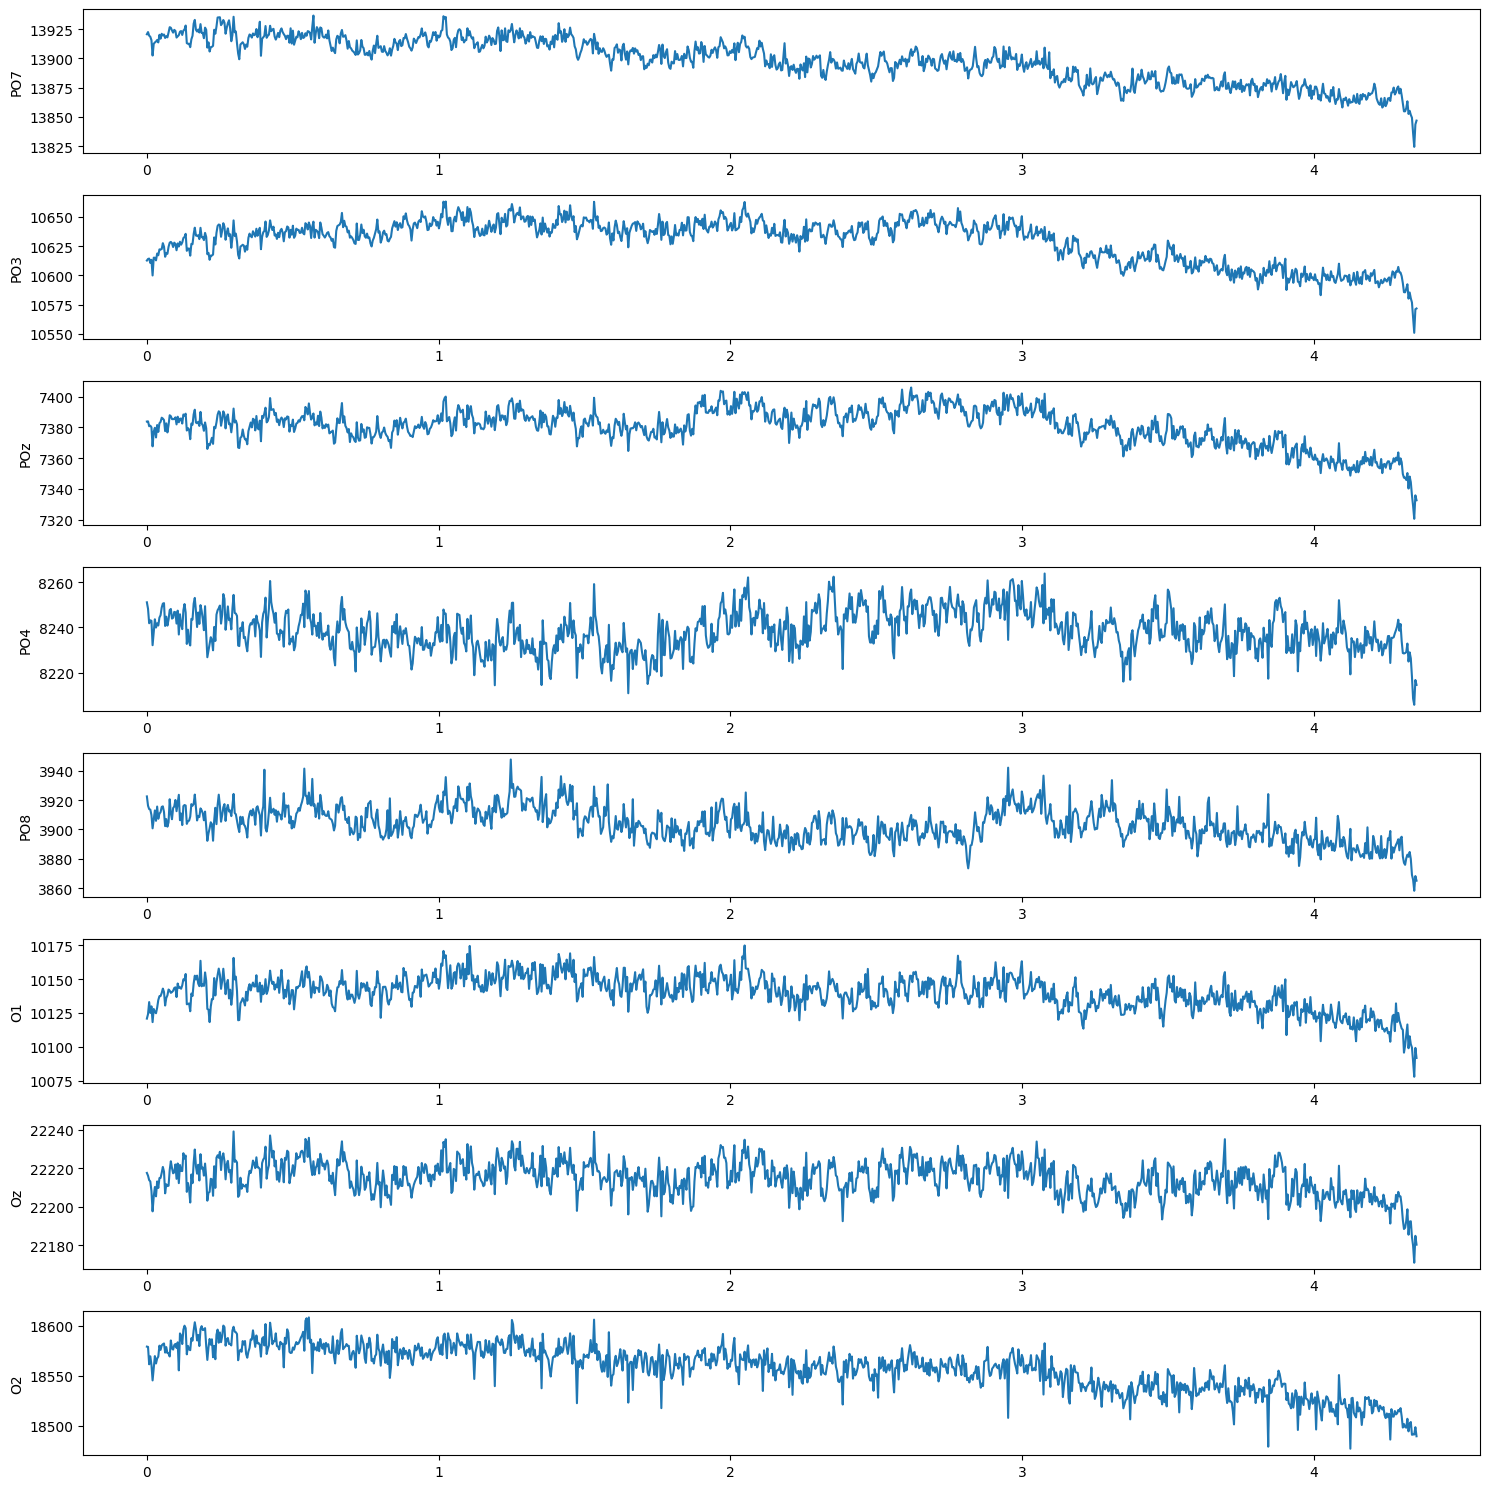

In [5]:
time = np.linspace(0, 1114/256, 1114)
fig, axs = plt.subplots(8, 1)
fig.set_figheight(15)
fig.set_figwidth(15)


for i in range(8):
    axs[i].plot(time, eeg_data[0, i, :, 0])
    axs[i].set_ylabel(chan_locs[i])

fig.tight_layout()
plt.show()

# Filtered Data

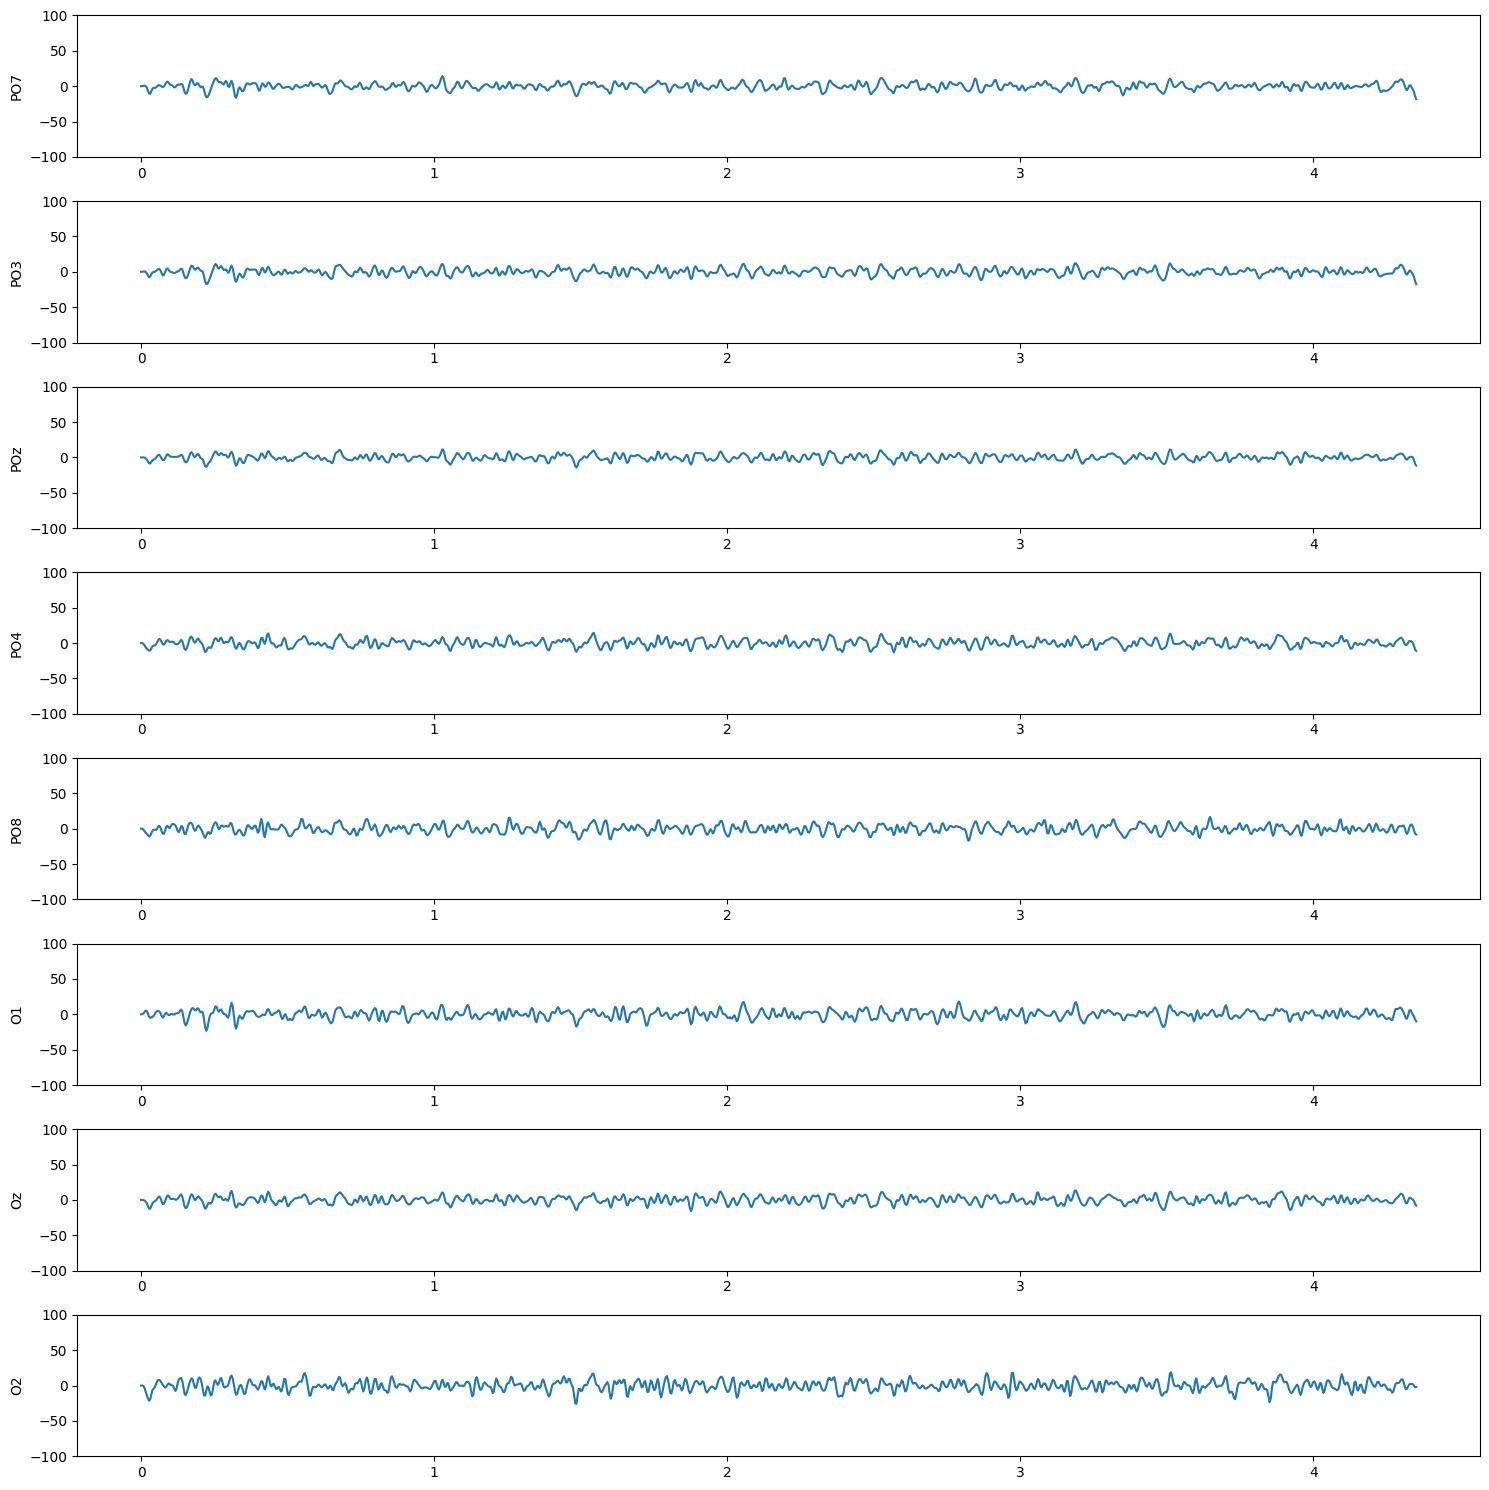

In [44]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data



fps = 256  # sampling frequency
cutoff_high = 6  # cutoff frequency of the high-pass filter
cutoff_low = 50  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency).  It represents the highest frequency that can be accurately represented in a discrete-time signal.

time = np.linspace(0, 1114/256, 1114)
fig, axs = plt.subplots(8, 1)
fig.set_figheight(15)
fig.set_figwidth(15)


for i in range(8):
    temp_epoch = np.array(eeg_data[0, i, :, 0]).flatten()

    # apply the band-pass filter
    temp_epoch = butter_highpass_filter(
        data=temp_epoch,
        cutoff=cutoff_high,
        nyq=nyq,
        order=4)
    
    temp_epoch = butter_lowpass_filter(
        data=temp_epoch,
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)
    
    axs[i].plot(time, temp_epoch)
    axs[i].set_ylabel(chan_locs[i])
    axs[i].set_ylim(-100, 100)

fig.tight_layout()
plt.show()

# Filter Dataset

In [45]:
filtered_9hz = []

for j in range(15):

    trial_ = []
    for i in range(8):
        temp_epoch = np.array(eeg_data[0, i, :, j]).flatten()

        # apply the band-pass filter
        temp_epoch = butter_highpass_filter(
            data=temp_epoch,
            cutoff=cutoff_high,
            nyq=nyq,
            order=4)

        temp_epoch = butter_lowpass_filter(
            data=temp_epoch,
            cutoff=cutoff_low,
            nyq=nyq,
            order=4)

        trial_.append(temp_epoch)

    filtered_9hz.append(trial_)

(1.0, 40.0)

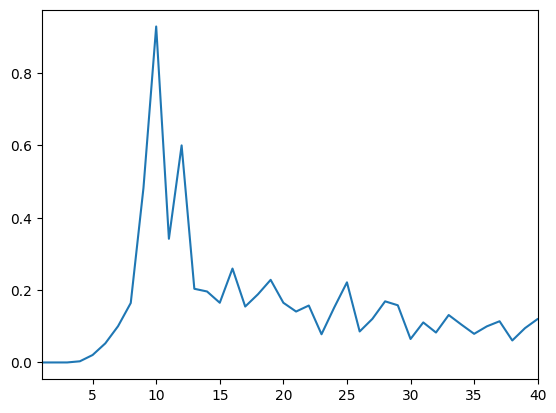

In [46]:
nfft = DataFilter.get_nearest_power_of_two(256)
psd = DataFilter.get_psd_welch(filtered_9hz[11][6], nfft, nfft // 2, 256, WindowOperations.HANNING.value)

plt.plot(psd[1], psd[0])
plt.xlim(1, 40)

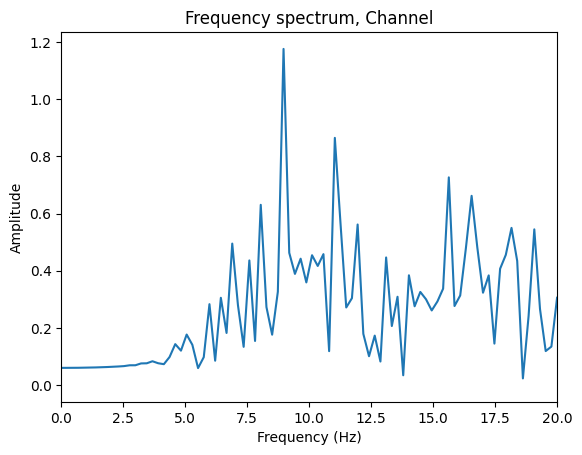

In [50]:
data_ = filtered_9hz[0][7]
data_len = len(data_)  # number of observations
fourier_transform = np.fft.fft(data_)  # compute FFT
fourier_transform = fourier_transform / data_len  # normalize values
fourier_transform = fourier_transform[:int(data_len/2)]  # take half of the data

time_period = data_len / fps  # time period of the signal
values = np.arange(int(data_len/2))  # x-axis values up to Nyquist frequency
frequencies = values / time_period  # x-axis values in Hz

# plot the frequency spectrum
plt.plot(frequencies, abs(fourier_transform))
plt.title("Frequency spectrum, Channel")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0, 20])
plt.show()

In [51]:
def closest(lst, K):
    return (np.abs(lst - K)).argmin()

target_frequencies = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

In [52]:
for i in target_frequencies:
    ind = closest(frequencies, i)
    val = abs(fourier_transform)[ind]
    print(f'{i} Hz has power: {val}')

9.25 Hz has power: 0.46248672318096745
11.25 Hz has power: 0.5641782321721466
13.25 Hz has power: 0.20625321935916305
9.75 Hz has power: 0.4419287546171536
11.75 Hz has power: 0.30370475591774776
13.75 Hz has power: 0.03382943313797339
10.25 Hz has power: 0.41649975036035053
12.25 Hz has power: 0.17878437506299902
14.25 Hz has power: 0.27533190245897365
10.75 Hz has power: 0.11828053687260806
12.75 Hz has power: 0.1726943042431153
14.75 Hz has power: 0.2998358525904227
